# Q-Learning For House Navigation Task


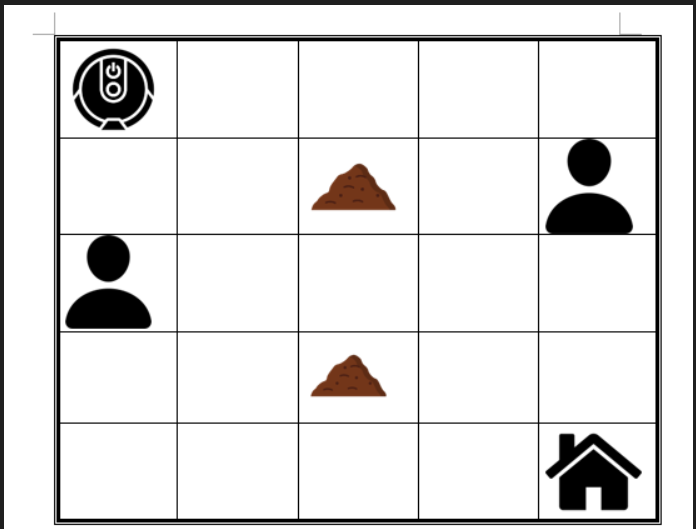

![image.png](attachment:image.png)

In [2]:
# Here we will use numpy arrays
import numpy as np
import pandas as pd

## Define State and Action spaces

Here we use discrete sets of states and actions.


In [3]:
grid_size = 5

person_reward = -5
dirt_collect_reward = 5
no_collect_reward = -5
goal_reward = 10
move_reward = -1

person_locations = [(3, 2), (1, 3)]
dirt_locations = [(2, 4), (1, 2), (3, 1)]
final_state = (grid_size - 1, grid_size - 1)

environment = np.ones((grid_size, grid_size), dtype=np.int32) * move_reward

# Persons (-ve reward)
for x, y in person_locations:
    environment[x, y] = person_reward

# Dirt (+ve reward)
for x, y in dirt_locations:
    environment[x, y] = dirt_collect_reward

# Return home
environment[final_state[0], final_state[1]] = goal_reward
environment

array([[-1, -1, -1, -1, -1],
       [-1, -1,  5, -5, -1],
       [-1, -1, -1, -1,  5],
       [-1,  5, -5, -1, -1],
       [-1, -1, -1, -1, 10]])

In [4]:
# Initialize an empty list to store state representations
S = []

# Looping through each grid cell
for i in range(grid_size):
    for j in range(grid_size):

        # Checking if the current cell contains a person
        if (i, j) in person_locations:
            # Appending the state representation for a cell with a person
            S.append(f'{i}_{j}_0_1')

        # Checking if the current cell contains dirt
        elif (i, j) in dirt_locations:
            # Appending the state representation for a cell with dirt
            S.append(f'{i}_{j}_1_0')

        # If the cell is empty
        else:
            S.append(f'{i}_{j}_0_0')

# Defining the set of possible actions
A = ['U', 'D', 'L', 'R', 'C']
S

['0_0_0_0',
 '0_1_0_0',
 '0_2_0_0',
 '0_3_0_0',
 '0_4_0_0',
 '1_0_0_0',
 '1_1_0_0',
 '1_2_1_0',
 '1_3_0_1',
 '1_4_0_0',
 '2_0_0_0',
 '2_1_0_0',
 '2_2_0_0',
 '2_3_0_0',
 '2_4_1_0',
 '3_0_0_0',
 '3_1_1_0',
 '3_2_0_1',
 '3_3_0_0',
 '3_4_0_0',
 '4_0_0_0',
 '4_1_0_0',
 '4_2_0_0',
 '4_3_0_0',
 '4_4_0_0']

In [5]:
from typing import Tuple

# Function to parse the state string and return its components
def parse_state(state: str) -> Tuple[int, int, str]:
    x, y, dirt, person = state.split("_")


    # Converting 'x' and 'y' coordinates to integers
    # Converting 'dirt' and 'person' flags to boolean values
    return x, y, dirt == 1, person == 1

## Define R Matrix

R matrix indicates the actions which are possible from any given state, along with the numeric reward for every possible action in each state.

The R matrix is part of the environment. It is constructed by the task designer, and the agent is unable to change it in any way.

We use **np.NaN** (i.e. "not a number") to indicate actions which are impossible.

Note: Numpy indexes by 0, so the indices in the R matrix for this example go from 0 to 5 instead of 1 to 6.

nan indicates impossible move <br>
100 indicates destination (door)


In [23]:
import numpy as np
import pandas as pd

# Initialize a numpy array filled with NaN values
R = np.full((len(S), len(A)), np.nan)

# Iterate through each row and column in the environment
for row, _ in enumerate(environment):
    for column, _ in enumerate(environment[row]):
        
        # Check the cell above the current cell
        if row > 0:
            # Check if the cell above contains a person
            if (row-1, column) in person_locations:
                R[row * grid_size + column, 0] = person_reward
            # Check if the cell above is the final state
            elif (row - 1, column) == final_state:
                R[row * grid_size + column, 0] = goal_reward
            else:
                R[row * grid_size + column, 0] = -1
        
        # Check the cell below the current cell
        if row < grid_size - 1:
            if (row+1, column) in person_locations:
                R[row * grid_size + column, 1] = person_reward
            elif (row - 1, column) == final_state:
                R[row * grid_size + column, 1] = goal_reward
            else:
                R[row * grid_size + column, 1] = -1
        
        # Check the cell to the left of the current cell
        if column > 0:
            if (row, column-1) in person_locations:
                R[row * grid_size + column, 2] = person_reward
            elif (row - 1, column) == final_state:
                R[row * grid_size + column, 2] = goal_reward
            else:
                R[row * grid_size + column, 2] = -1
        
        # Check the cell to the right of the current cell
        if column < grid_size - 1:
            if (row, column+1) in person_locations:
                R[row * grid_size + column, 3] = person_reward
            elif (row - 1, column) == final_state:
                R[row * grid_size + column, 3] = goal_reward
            else:
                R[row * grid_size + column, 3] = -1
        
        # Check if the current cell contains dirt
        if (row, column) in dirt_locations:
            R[row * grid_size + column, 4] = dirt_collect_reward
        else:
            R[row * grid_size + column, 4] = no_collect_reward

# Print the reward matrix
print(R)

# Create a pandas DataFrame from the reward matrix
R_df = pd.DataFrame(R, columns=A, index=S)

R_df


[[nan -1. nan -1. -5.]
 [nan -1. -1. -1. -5.]
 [nan -1. -1. -1. -5.]
 [nan -5. -1. -1. -5.]
 [nan -1. -1. nan -5.]
 [-1. -1. nan -1. -5.]
 [-1. -1. -1. -1. -5.]
 [-1. -1. -1. -5.  5.]
 [-1. -1. -1. -1. -5.]
 [-1. -1. -5. nan -5.]
 [-1. -1. nan -1. -5.]
 [-1. -1. -1. -1. -5.]
 [-1. -5. -1. -1. -5.]
 [-5. -1. -1. -1. -5.]
 [-1. -1. -1. nan  5.]
 [-1. -1. nan -1. -5.]
 [-1. -1. -1. -5.  5.]
 [-1. -1. -1. -1. -5.]
 [-1. -1. -5. -1. -5.]
 [-1. -1. -1. nan -5.]
 [-1. nan nan -1. -5.]
 [-1. nan -1. -1. -5.]
 [-5. nan -1. -1. -5.]
 [-1. nan -1. -1. -5.]
 [-1. nan -1. nan -5.]]


,U,D,L,R,C
0_0_0_0,NaN,-1.0,NaN,-1.0,-5.0
0_1_0_0,NaN,-1.0,-1.0,-1.0,-5.0
0_2_0_0,NaN,-1.0,-1.0,-1.0,-5.0
0_3_0_0,NaN,-5.0,-1.0,-1.0,-5.0
0_4_0_0,NaN,-1.0,-1.0,NaN,-5.0
1_0_0_0,-1.0,-1.0,NaN,-1.0,-5.0
1_1_0_0,-1.0,-1.0,-1.0,-1.0,-5.0
1_2_1_0,-1.0,-1.0,-1.0,-5.0,5.0
1_3_0_1,-1.0,-1.0,-1.0,-1.0,-5.0
1_4_0_0,-1.0,-1.0,-5.0,NaN,-5.0


## Define Q Matrix

The Q matrix indicates the agent's valuation for the given state and action pair. In other words, the agent's expected return for taking the given action in the given state.

When the agent knows the number of possible states and actions already, the Q matrix is the same size as the R matrix. The indices are the same, ie row 0 indicates state A etc in the Q matrix as well as the R matrix.

We initialize the Q matrix with zeros. Right now, the agent **doesn't know anything about the value of any given action in any given state, and it also doesn't know which actions are possible in which state yet.**


In [7]:
Q = np.zeros(R.shape)

print('Q matrix: \n\n{}'.format(Q))

Q matrix: 

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


## Begin!

Okay now we're ready for our agent to start learning. We will do the first timestep step-by-step to see how it works, and then see how it all comes together by looping over timesteps within a single episode.

### Initialize State

Here we randomly initialize the state (ie randomly select which room the agent starts in) to begin the episode.


In [8]:
# FILL IN

s = 0

print("Starting state is '{}', which is row {} in the Q and R matrices".format(
    S[s], s))

Starting state is '0_0_0_0', which is row 0 in the Q and R matrices


### Identify Available Actions for State

Now we identify which are our available actions in this state from the R matrix.

Note: the available actions are the elements which are NOT nan from the row of the R matrix corresponding to current state.


In [9]:
available_actions = np.where(~np.isnan(R[s]))[0]
print(available_actions)

[1 3 4]


In [10]:
R[s]

array([nan, -1., nan, -1., -5.])

In [11]:
a_idx = list(available_actions)
a_labels = [A[x] for x in available_actions]
q_values = [Q[s, a] for a in a_idx]

print('Available actions are: {}'.format(a_labels))
print('Those actions correspond to column indices: {}'.format(a_idx))
print('Those actions have estimated values: {}'.format(q_values))

Available actions are: ['D', 'R', 'C']
Those actions correspond to column indices: [1, 3, 4]
Those actions have estimated values: [0.0, 0.0, 0.0]


### Select Action

Here we are using a **greedy behavioural policy**, so we always choose the action with the highest value. Ties are broken at random.

Later in the notebook we switch to epsilon-greedy, which chooses a greedy action with probability 0.9 and a random action with probability 0.1.


In [12]:
best_actions = available_actions[np.where(q_values == np.max(q_values))[0]]
best_actions_labels = [A[x] for x in best_actions]
best_actions_q_values = [Q[s, a] for a in best_actions]

In [13]:
print(f"best actions (indices) are {best_actions}")
print(f"The labels associated with the best actions are {best_actions_labels}")
print(f"q values for the best actions are {best_actions_q_values}")

best actions (indices) are [1 3 4]
The labels associated with the best actions are ['D', 'R', 'C']
q values for the best actions are [0.0, 0.0, 0.0]


In [14]:
print("Our best available actions from state '{}' are: {} with current q values: {}".format(S[s],
                                                                                            best_actions_labels, best_actions_q_values))

a = np.random.choice(best_actions)

print("Randomly selecting action '{}' with current Q value {}".format(
    A[a], Q[s, a]))

Our best available actions from state '0_0_0_0' are: ['D', 'R', 'C'] with current q values: [0.0, 0.0, 0.0]
Randomly selecting action 'C' with current Q value 0.0


## Update Environment (According to Action Selected by Agent)

### Determine reward

The reward is issued by the environment given the state and action pair


In [15]:
r = R[s, a]
print("Reward for taking action '{}' from state '{}': {}".format(
    A[a], S[s], r))

Reward for taking action 'C' from state '0_0_0_0': -5.0


### Update State

The environment state updates given the state action pair


In [16]:
s_old = s
# here, the transition function is deterministic. Next state corresponds simply to the action taken.
if A[a] == 'U':
    s -= 5
elif A[a] == 'D':
    s += 5
elif A[a] == 'L':
    s -= 1
elif A[a] == 'R':
    s += 1
print("After taking action '{}' from state '{}', new state is '{}'".format(
    A[a], S[s_old], S[s]))

After taking action 'C' from state '0_0_0_0', new state is '0_0_0_0'


## Update Q Matrix

Now that the agent has observed some reward, it can update its internal value estimates.

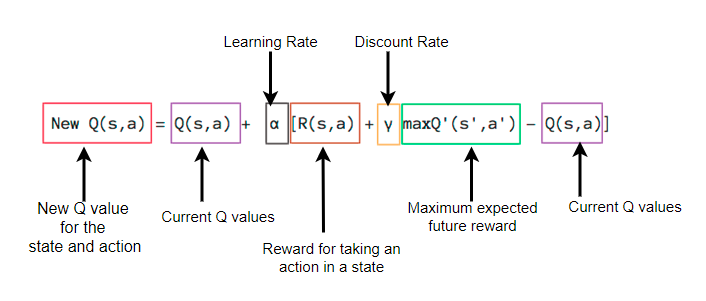


### Parameters Initializations


In [17]:
alpha = 1
gamma = 0.8
epsilon = 0.9

### Use the equation above to update Q Values

Specifically we are going to update Q[s_old,a] value <br>
**to think. What is maxQ(s,a) in the equation?**


## Run An Episode

Run the cell below to run a single episode.

All information is printed in the cell output.

How many episodes do you have to run to get to the final Q values?


## Run Until Convergence

Run many episodes until Q matrix converges to final values


In [18]:
def epsilon_greedy(R, A, goal_state, alpha=1, gamma=0.8, epsilon=0.9, episodes=1000, timestep_per_episode=500, verbose=False):
    if verbose:
        print(R, A, goal_state, alpha, gamma,
              epsilon, episodes, timestep_per_episode)
    Q = np.zeros(R.shape)
    episode_q_means = []
    episode_rewards = []
    # Run for episodes
    for episode in range(episodes):
        s = 0
        if verbose:
            print("Starting state is '{}'".format(S[s]))

        episode_reward = 0
        for _ in range(timestep_per_episode):
            # Action selection
            available_actions = np.where(~np.isnan(R[s]))[0]
            q_values = [Q[s, a] for a in available_actions]
            best_actions = available_actions[np.where(
                q_values == np.max(q_values))[0]]
            best_actions_q_values = [Q[s, x] for x in best_actions]

            # Epsilon-greedy
            if np.random.uniform() > epsilon:
                a = np.random.choice(available_actions)
            else:
                a = np.random.choice(best_actions)

            # Environment updating

            r = R[s, a]

            state_name = S[s]
            x, y, dirt, person = parse_state(state_name)
            if (x, y) in dirt_locations and a == 4:
                dirt_locations.remove((x, y))
                R[s, a] = move_reward
            s_old = s
            # here, the transition function is deterministic. Next state corresponds simply to the action taken.
            if A[a] == 'U':
                s -= 5
            elif A[a] == 'D':
                s += 5
            elif A[a] == 'L':
                s -= 1
            elif A[a] == 'R':
                s += 1
            if verbose:
                print("After taking action '{}' from state '{}', new state is '{}'".format(
                    A[a], S[s_old], S[s]))

            episode_reward += r

            # FILL IN

            # Q value updating
            Q[s_old, a] += alpha * \
                (r + gamma * np.max(Q[s]) - Q[s_old, a])

            if S[s] == goal_state:
                break
        if verbose:
            print('Episode {} finished. Q matrix values:\n{}'.format(
                episode, Q.round(1)))
        episode_q_means.append(np.mean(Q))
        episode_rewards.append(episode_reward)
    return episode_q_means, episode_rewards, Q

# Further exercises:

- Explore the impact of different parameters (e.g. learning rate, discount rate), experiment with different values
- Plot observations for different parameter values
- Perform a grid search to find the optimal combination
- In preparation for next week's lab, try to apply Q-Learning to your selected domain and repeat the above tasks


In [19]:
q_means, rewards, Q = epsilon_greedy(
    R.copy(), A.copy(), S[-1], alpha, gamma, epsilon, verbose=True)

[[nan -1. nan -1. -5.]
 [nan -1. -1. -1. -5.]
 [nan -1. -1. -1. -5.]
 [nan -5. -1. -1. -5.]
 [nan -1. -1. nan -5.]
 [-1. -1. nan -1. -5.]
 [-1. -1. -1. -1. -5.]
 [-1. -1. -1. -5.  5.]
 [-1. -1. -1. -1. -5.]
 [-1. -1. -5. nan -5.]
 [-1. -1. nan -1. -5.]
 [-1. -1. -1. -1. -5.]
 [-1. -5. -1. -1. -5.]
 [-5. -1. -1. -1. -5.]
 [-1. -1. -1. nan  5.]
 [-1. -1. nan -1. -5.]
 [-1. -1. -1. -5.  5.]
 [-1. -1. -1. -1. -5.]
 [-1. -1. -5. -1. -5.]
 [-1. -1. -1. nan -5.]
 [-1. nan nan -1. -5.]
 [-1. nan -1. -1. -5.]
 [-5. nan -1. -1. -5.]
 [-1. nan -1. -1. -5.]
 [-1. nan -1. nan -5.]] ['U', 'D', 'L', 'R', 'C'] 4_4_0_0 1 0.8 0.9 1000 500
Starting state is '0_0_0_0'
After taking action 'R' from state '0_0_0_0', new state is '0_1_0_0'
After taking action 'R' from state '0_1_0_0', new state is '0_2_0_0'
After taking action 'D' from state '0_2_0_0', new state is '1_2_1_0'
After taking action 'D' from state '1_2_1_0', new state is '2_2_0_0'
After taking action 'R' from state '2_2_0_0', new state is '2_3_0_0

After taking action 'C' from state '1_2_1_0', new state is '1_2_1_0'
After taking action 'C' from state '1_2_1_0', new state is '1_2_1_0'
After taking action 'C' from state '1_2_1_0', new state is '1_2_1_0'
After taking action 'C' from state '1_2_1_0', new state is '1_2_1_0'
After taking action 'U' from state '1_2_1_0', new state is '0_2_0_0'
After taking action 'D' from state '0_2_0_0', new state is '1_2_1_0'
After taking action 'C' from state '1_2_1_0', new state is '1_2_1_0'
After taking action 'C' from state '1_2_1_0', new state is '1_2_1_0'
After taking action 'C' from state '1_2_1_0', new state is '1_2_1_0'
After taking action 'C' from state '1_2_1_0', new state is '1_2_1_0'
After taking action 'C' from state '1_2_1_0', new state is '1_2_1_0'
After taking action 'C' from state '1_2_1_0', new state is '1_2_1_0'
After taking action 'C' from state '1_2_1_0', new state is '1_2_1_0'
After taking action 'C' from state '1_2_1_0', new state is '1_2_1_0'
After taking action 'C' from state

KeyboardInterrupt: 

In [ ]:
print('Final Q matrix: \n{}'.format(Q.round(0)))

Final Q matrix: 
[[ 0. 10.  0. 10.  3.]
 [ 0. 14.  7. 14.  6.]
 [ 0. 19. 10. 10. 10.]
 [ 0. 10. 14. 10.  6.]
 [ 0. 14. 10.  0.  6.]
 [ 7. 10.  0. 14.  6.]
 [10. 14. 10. 19. 10.]
 [14. 14. 14. 10. 25.]
 [10. 14. 19. 14. 10.]
 [10. 19. 10.  0. 10.]
 [-1. 14.  0. 14.  6.]
 [14. 19. 10. 14. 10.]
 [19. 10. 14. 14. 10.]
 [10. 10. 14. 19. 10.]
 [14. 14. 14.  0. 25.]
 [10. 10.  0. 19. 10.]
 [14. 14. 14. 10. 25.]
 [14. 10. 19. 10. 10.]
 [14.  7. 10. 14.  6.]
 [19. -1. 10.  0. 10.]
 [14.  0.  0. 14.  6.]
 [19.  0. 10. 10. 10.]
 [10.  0. 14.  7.  6.]
 [-1.  0. 10. -1. -5.]
 [ 0.  0.  0.  0.  0.]]


In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

param_range = np.arange(0.1, 1.0, 0.4)
grid = ParameterGrid(
    {'alpha': param_range, 'gamma': param_range, 'epsilon': param_range})

all_q_means, all_rewards, all_labels = [], [], []
for params in tqdm(grid):
    parameter_q_means, parameter_rewards, Q = epsilon_greedy(
        R.copy(), A.copy(), S[-1], **params)
    all_q_means.append(parameter_q_means)
    all_rewards.append(parameter_rewards)
    all_labels.append(
        f'a={params["alpha"]}\ng={params["gamma"]}\ne={params["epsilon"]}')

100%|██████████| 27/27 [01:43<00:00,  3.83s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


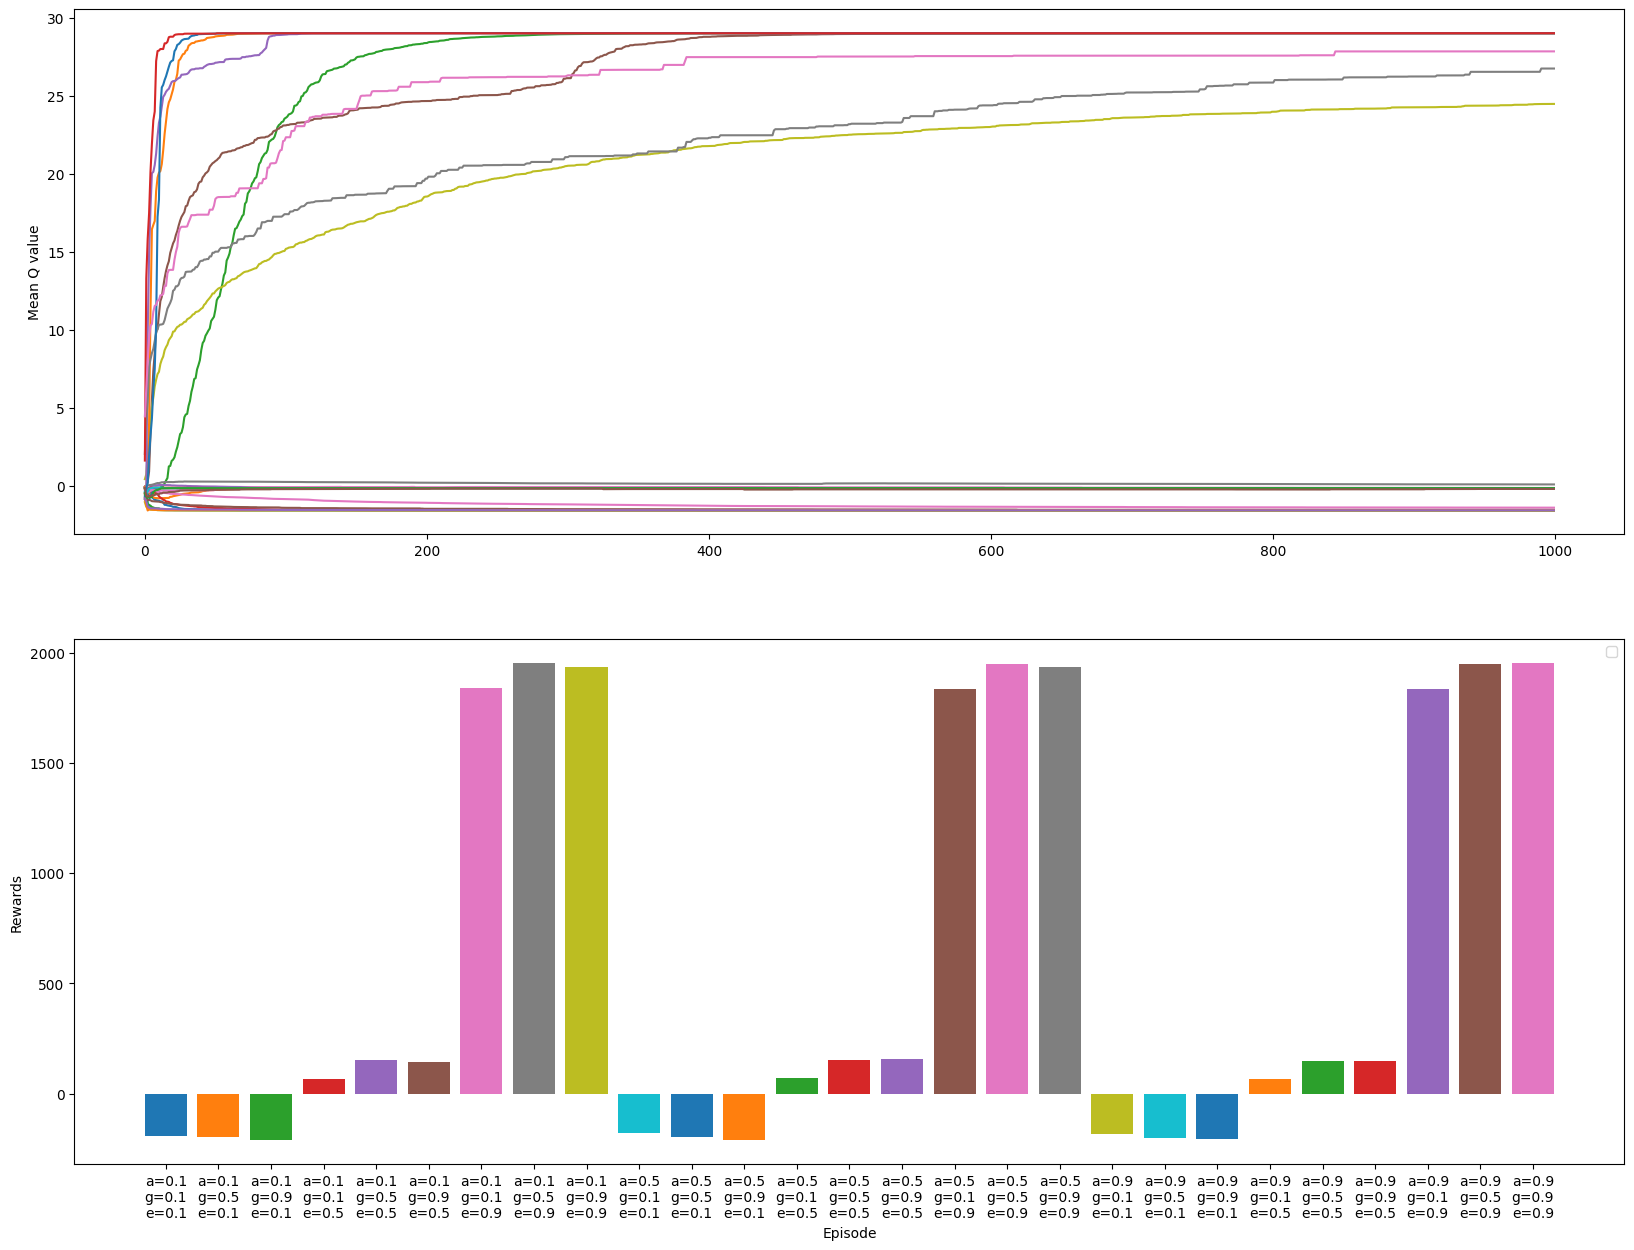

In [ ]:
fig, ax = plt.subplots(2, figsize=(20, 15))
plt.xlabel('Episode')
ax[0].set_ylabel('Mean Q value')
ax[1].set_ylabel('Rewards')
for i, (q_means, rewards, label) in enumerate(zip(all_q_means, all_rewards, all_labels)):
    ax[0].plot(q_means, label=label)
    ax[1].bar(label, height=np.mean(rewards))
plt.legend()

/var/folders/tr/8l927lgj3tg3pvttn4xvpq3h0000gn/T/ipykernel_42307/3104463682.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_labels[:5], y=sorted_reward_means[:5], palette='Set3')


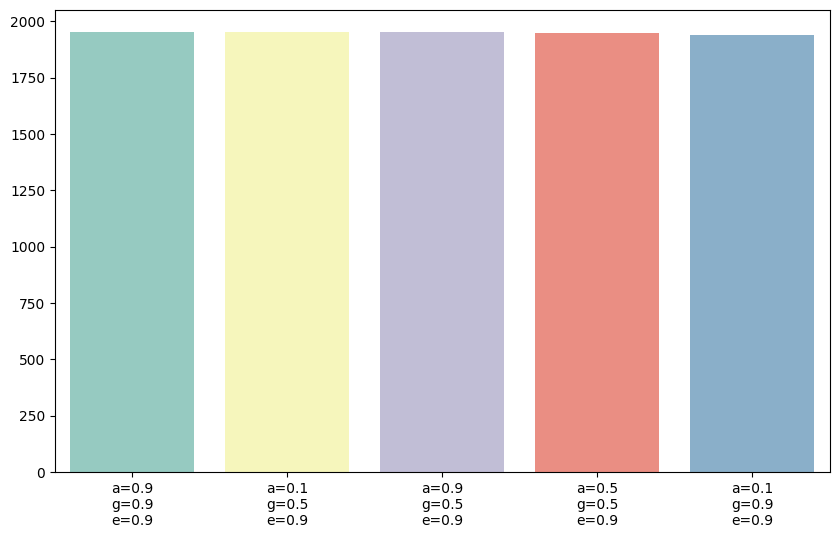

In [ ]:
%matplotlib inline
import seaborn as sns

reward_means = np.mean(all_rewards, axis=1)

sorted_arrays = sorted(zip(reward_means, all_labels, all_q_means), key=lambda x: x[0], reverse=True)
sorted_reward_means, sorted_labels, sorted_q_means = zip(*sorted_arrays)
plt.figure(figsize=(10, 6))

sns.barplot(x=sorted_labels[:5], y=sorted_reward_means[:5], palette='Set3')

plt.show()

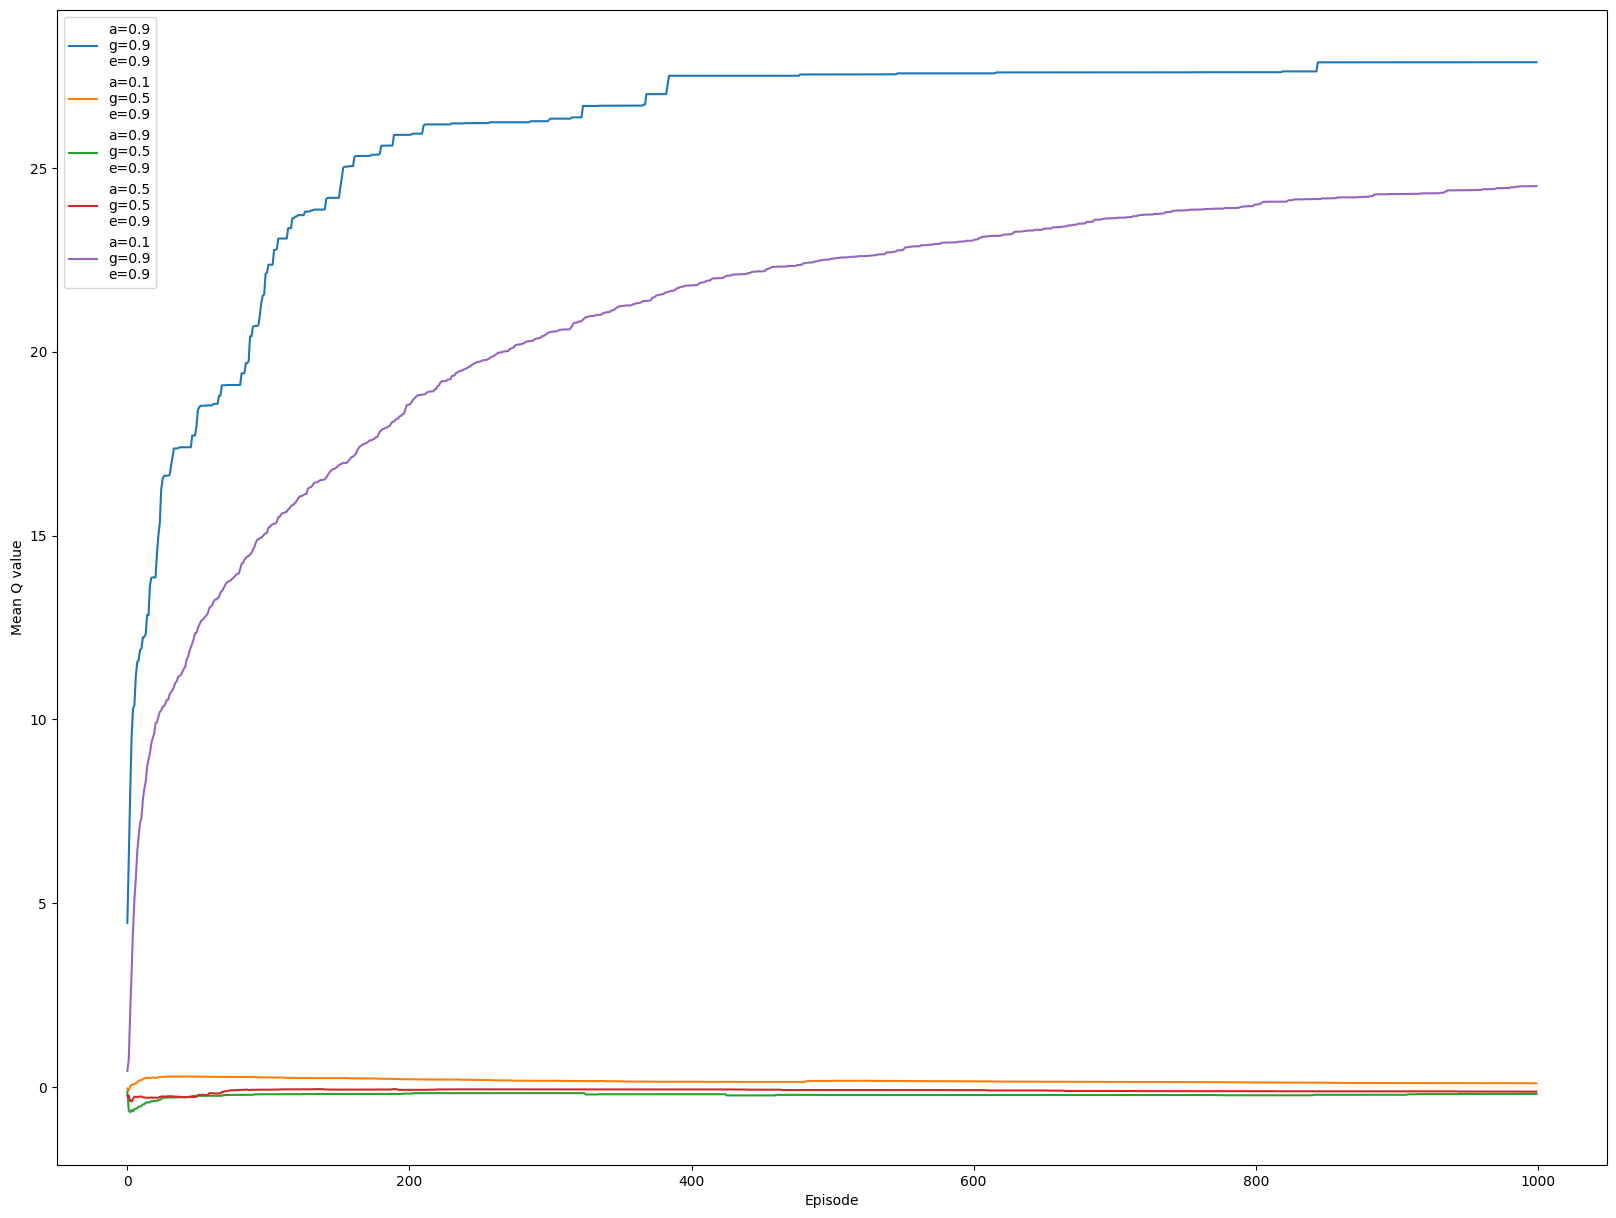

In [ ]:
fig, ax = plt.subplots(1, figsize=(20, 15))
plt.xlabel('Episode')
ax.set_ylabel('Mean Q value')
for i, (q_means, label) in enumerate(zip(sorted_q_means[:5], sorted_labels[:5])):
    ax.plot(q_means, label=label)
plt.legend()